# Logistic Regression

In [28]:
from __future__ import division, print_function
from sklearn.linear_model import LogisticRegression
from matplotlib import rcParams, pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sys import stdout
from math import pi
import pandas as pd
import numpy as np

%matplotlib inline
rcParams["figure.figsize"] = (15,5)

#### Problem 1

In [29]:
def process_titanic_data(filename="titanic.csv", pclass_change=True):

    data = pd.read_csv(filename)
    data.drop(["Name", "Ticket", "Cabin", "Boat", "Body", "home.dest"], axis=1, inplace=True)
    data.dropna(inplace=True)
    data.loc[data.Sex=="female", "Sex"] = 0
    data.loc[data.Sex=="male", "Sex"] = 1
    data.loc[data.Embarked=='S', 'Embarked'] = 0
    data.loc[data.Embarked=='C', 'Embarked'] = 1
    data.loc[data.Embarked=='Q', 'Embarked'] = 2
    
    if pclass_change is True:
        pclass = data["Pclass"]
        data["SecondClass"] = [1 if 2==pclass[i] else 0 for i in pclass.index]
        data["FirstClass"] = [1 if 1==pclass[i] else 0 for i in pclass.index]
        data.drop("Pclass", axis=1, inplace=True)

    test_index = sorted(np.random.choice(data.index, int(len(data.index)*.4), replace=False))
    train_index = [i for i in data.index if i not in test_index]
    
    return data.loc[train_index], data.loc[test_index]

utraining, utesting = process_titanic_data(pclass_change=False)
ctraining, ctesting = process_titanic_data(pclass_change=True)

ctesting

,Survived,Sex,Age,Sibsp,Parch,Fare,Embarked,SecondClass,FirstClass
1,1,1,0.9167,1,2,151.5500,0,0,1
4,0,0,25.0000,1,2,151.5500,0,0,1
5,1,1,48.0000,0,0,26.5500,0,0,1
10,0,1,47.0000,1,0,227.5250,1,0,1
17,1,0,50.0000,0,1,247.5208,1,0,1
20,1,1,37.0000,1,1,52.5542,0,0,1
22,1,1,26.0000,0,0,30.0000,1,0,1
30,0,1,45.0000,0,0,35.5000,0,0,1
31,1,1,40.0000,0,0,31.0000,1,0,1
32,1,0,30.0000,0,0,164.8667,0,0,1


#### Problem 2

In [30]:
def best_tau(predicted_labels, true_labels, n_tau=100, plot=True):

    tau_space = np.linspace(0,1,n_tau)

    def accuracy(tau):
        
        TP = np.sum((predicted_labels >=tau)*true_labels)
        FP = np.sum((predicted_labels >=tau)*true_labels)
        TN = np.sum((predicted_labels < tau)*true_labels)
        FN = np.sum((predicted_labels < tau)*true_labels)

        if not TP+FP+TN+FN == len(predicted_labels):
            raise ValueError("Some labels not accounted for")

        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        return TPR - FPR
    
    points = [accuracy(t) for t in tau_space]
    if plot:
        plt.plot(tau_space, points)
        plt.show()
    
    return tau_space[np.argmax(points)]

#### Problem 3, 4

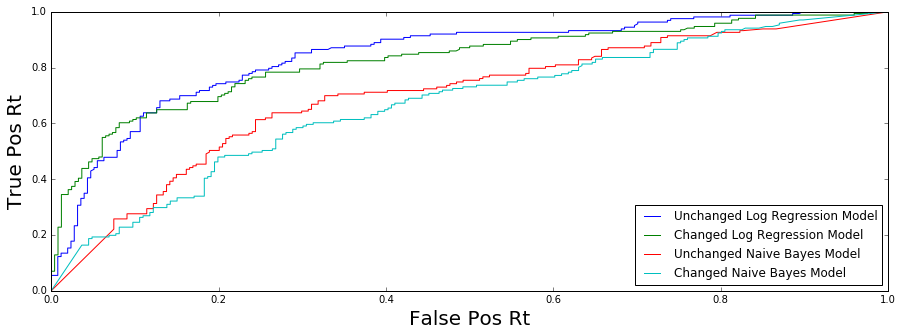

auc scores: (0.84370320274382882, 0.82551229021062156, 0.69986957151828422, 0.66907954167260975)


In [ ]:
def auc_score(unchanged_logreg, changed_logreg, unchanged_bayes, changed_bayes, plot=False):

    unchanged_labels = utraining["Survived"]
    unchanged_data = utraining.drop("Survived", axis=1)
    
    changed_labels = ctraining["Survived"]
    changed_data = ctraining.drop("Survived", axis=1)
    
    unchanged_test_labels = utesting["Survived"]
    unchanged_test_data = utesting.drop("Survived", axis=1)
    
    changed_test_labels = ctesting["Survived"]
    changed_test_data = ctesting.drop("Survived", axis=1)  
    
    lr_unchanged = LogisticRegression(C=unchanged_logreg)
    lr_changed = LogisticRegression(C=changed_logreg)
    
    nb_unchanged = MultinomialNB(alpha=unchanged_bayes)
    nb_changed = MultinomialNB(alpha=changed_bayes)
    
    lr_unchanged.fit(unchanged_data, unchanged_labels)
    lr_changed.fit(changed_data, changed_labels)
    
    nb_unchanged.fit(unchanged_data, unchanged_labels)
    nb_changed.fit(changed_data, changed_labels)
    
    lr_unchanged_prob = lr_unchanged.predict_proba(unchanged_test_data)
    lr_changed_prob = lr_changed.predict_proba(changed_test_data)
    
    nb_unchanged_prob = nb_unchanged.predict_proba(unchanged_test_data)
    nb_changed_prob = nb_changed.predict_proba(changed_test_data)
    
    u_lr_FPR, u_lr_TPR, _ = roc_curve(unchanged_test_labels, lr_unchanged_prob[:,1], pos_label=1)
    c_lr_FPR, c_lr_TPR, _ = roc_curve(changed_test_labels, lr_changed_prob[:,1], pos_label=1)

    u_nb_FPR, u_nb_TPR, _ = roc_curve(unchanged_test_labels, nb_unchanged_prob[:,1], pos_label=1)
    c_nb_FPR, c_nb_TPR, _ = roc_curve(changed_test_labels, nb_changed_prob[:,1], pos_label=1)
    
    if plot is True:
        plt.plot(u_lr_FPR, u_lr_TPR, label="Unchanged Log Regression Model")
        plt.plot(c_lr_FPR, c_lr_TPR, label="Changed Log Regression Model")
        plt.plot(u_nb_FPR, u_nb_TPR, label="Unchanged Naive Bayes Model")
        plt.plot(c_nb_FPR, c_nb_TPR, label="Changed Naive Bayes Model")
        plt.legend(loc="lower right")
        plt.ylabel("True Pos Rt", fontsize=20)
        plt.xlabel("False Pos Rt", fontsize=20)
        plt.show()

    return auc(u_lr_FPR, u_lr_TPR), auc(c_lr_FPR, c_lr_TPR), auc(u_nb_FPR, u_nb_TPR), auc(c_nb_FPR, c_nb_TPR)

scores = auc_score(.2, .4, .6, .8, True)
print("auc scores:", scores)

#### Problem 5

In [26]:
def find_best_parameters(n):
    domain = np.linspace(0,1,n+2)[1:-1]
    best = np.zeros(4)
    for d in domain:
        attempt = np.array(auc_score(d,d,d,d,plot=False))
        best = np.max(np.row_stack((attempt, best)), axis=0)
    return list(best)

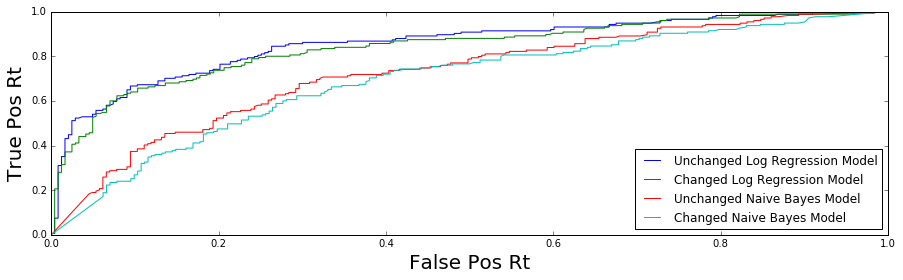

Params: [0.85604985573057091, 0.84004722550177102, 0.72534411806442467, 0.69416765053128682]
Scores: (0.85581334846979806, 0.83985832349468725, 0.72529681661226997, 0.69412042502951588)


In [27]:
params = find_best_parameters(100)
scores = auc_score(*params, plot=True)
print("Params:", params)
print("Scores:", scores)

In [19]:
#87115 647143474